In [13]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Just get 1000 data points and only the text columns

In [2]:
import torch
import numpy as np

/home/gwan/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.version.cuda

'11.7'

In [4]:
# key_word = ['very','pleasant'] #
# pattern = '|'.join(key_word)
# data['check'] = data['TEXT'].str.contains(pattern)
# data.check.value_counts()

In [7]:
sentences = train.text.values
sentences_test = test.text.values

## Transfomer based contextual embedding

In [18]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("TimKond/S-BioLinkBert-MedQuAD")

model = SentenceTransformer('TimKond/S-BioLinkBert-MedQuAD')

In [21]:
# Apprerantly Very simple embeddings clustering based on BERT does not tell anything about the sentiment
embeddings = model.encode(sentences)



In [34]:

embeddings_test = model.encode(sentences_test)

## 1: Machine learning based on embeddings

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight={0:1,1:100},max_features=20,max_depth = 20)

rf.fit(X = embeddings,y = train['annotation'])

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=20,
                       max_features=20)

In [77]:
y_test = test['annotation']
rf_pred = rf.predict(embeddings_test)
rf_pred_prob = rf.predict_proba(embeddings_test)

In [78]:
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
roc_auc_score(y_test,rf_pred_prob[:,1])

0.6278409090909092

In [79]:
train.annotation.value_counts()

0    363
1     62
Name: annotation, dtype: int64

In [80]:
test.annotation.value_counts()

0    96
1    11
Name: annotation, dtype: int64

/home/gwan/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


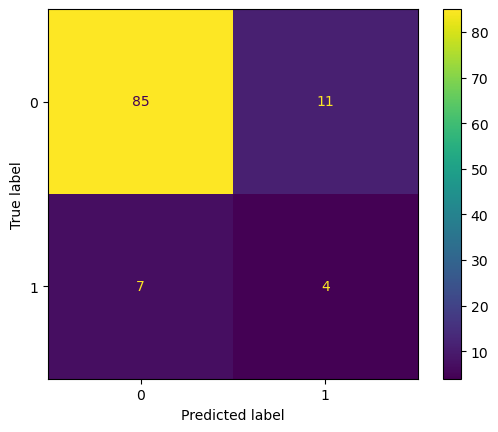

In [81]:
plot_confusion_matrix(rf,embeddings_test,y_test)

# 2: Pretrained Subjective BERT

In [8]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import pipeline
from scipy.special import softmax

2022-10-26 17:24:09.502227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 17:24:09.901328: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-26 17:24:10.046477: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 17:24:11.197281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [15]:
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
)

OSError: Can't load tokenizer for 'cffl/bert-base-styleclassification-subjective-neutral'. Make sure that:

- 'cffl/bert-base-styleclassification-subjective-neutral' is a correct model identifier listed on 'https://huggingface.co/models'
  (make sure 'cffl/bert-base-styleclassification-subjective-neutral' is not a path to a local directory with something else, in that case)

- or 'cffl/bert-base-styleclassification-subjective-neutral' is the correct path to a directory containing relevant tokenizer files



In [10]:
task='sentiment'
MODEL = "cffl/bert-base-styleclassification-subjective-neutral"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

OSError: Can't load tokenizer for 'cffl/bert-base-styleclassification-subjective-neutral'. Make sure that:

- 'cffl/bert-base-styleclassification-subjective-neutral' is a correct model identifier listed on 'https://huggingface.co/models'
  (make sure 'cffl/bert-base-styleclassification-subjective-neutral' is not a path to a local directory with something else, in that case)

- or 'cffl/bert-base-styleclassification-subjective-neutral' is the correct path to a directory containing relevant tokenizer files



In [104]:
encoded_sentence = tokenizer(sentences_test.tolist(),is_split_into_words=True, padding=True, truncation=True,max_length=512, add_special_tokens = True, return_tensors='pt')

In [105]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [106]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [107]:
from transformers import pipeline

output = model(**encoded_sentence)

: 

: 

In [37]:
positive = []
netural = []
negative = []

In [38]:
from copy import error


for i,row in test.iterrows():
    try:
        encoded_input = tokenizer(row['text'], return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        positive.append(scores[0])
        netural.append(scores[1])
        negative.append(scores[2])
    except:
        positive.append(1/3)
        netural.append(1/3)
        negative.append(1/3)
        print(i)

# ranking = np.argsort(scores)
# ranking = ranking[::-1]
# for i in range(scores.shape[0]):
#     l = labels[ranking[i]]
#     s = scores[ranking[i]]
#     print(f"{i+1}) {l} {np.round(float(s), 4)}")

9
15
30
35
38
39
46
49
52
68
76
78
96
97
102


In [ ]:
# Look at the confidence intervals of algorithm on the top10 20 and see if they agree with each other

In [39]:
test['postive'] = positive
test['negative'] = negative
test['neutal'] = netural

In [42]:
test['no_sentiment'] = 0
test.loc[test.neutal < 0.7,'no_sentiment'] = 1

In [44]:
test[test.annotation == 1].neutal.mean() # Subjetive label seems to be less neutral than the non-subjetive label

0.6024285139459552

In [45]:
test[test.annotation == 0].neutal.mean()

0.6978437507318128